## Terminal Reward and primitive AC model
##### In the more complex setting we need the bot to learn from experiences where it only gets rewarded and punished by either (1. Go bankrupt, 2. Reach the end of episode) with no intra-episode rewards. This is because non-risk-neutral investors' utility can't be decomposed into immediate step rewards

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

#### No change in NN and market setting, but investor utility no longer log-wealth

In [2]:
class NN():
    def __init__(self, Activation = 'Sigmoid', layers = [20, 10]):
        self._Activation_Method = Activation
        self._Weights = None
        self._Weight_Shape = layers
        
    def fit(self, X, Y, Loss, learn_rate = 0.001, Epoch = 50, **kwarg):
        if isinstance(X, list):
            Input_shape = len(X[0])
            X = np.array(X)
        elif isinstance(X, np.ndarray):
            Input_shape = X.shape[1]
        if isinstance(Y, list):
            Y = np.array(Y).reshape(-1,1)
            
        if self._Weights is None:
            ##Create the weights by initialising them as random values
            previous = Input_shape
            for Layer_Size in self._Weight_Shape:
                if self._Weights is None:
                    self._Weights = [np.random.rand(previous, Layer_Size)/((previous + Layer_Size)**0.5)]
                else:
                    Current_Layer = np.random.rand(previous, Layer_Size)/((previous + Layer_Size)**0.5)
                    self._Weights.append(Current_Layer)
                previous = Layer_Size
        else:
            pass
        
        for i in range(Epoch):
            ##Forward Propogation and record useful informations
            H_Collect = [X]
            A_Collect = []
            Derivative_Collect = []
            for idx, Weights in enumerate(self._Weights):
                if idx != len(self._Weights)-1:
                    Layer_Active = self._Activation_Method
                else:
                    Layer_Active = 'Identity'

                A = np.matmul(H_Collect[idx], Weights)
                H, derivative = self._Activation(A, how = Layer_Active)
                H_Collect.append(H)
                A_Collect.append(A)
                Derivative_Collect.append(derivative)

            ##Backward Propogation to calculate updated weights
            dW_Collect = []
            dA_Collect = []
            dH_Collect = []
            for idx, Hidden in enumerate(H_Collect[::-1]):
                if idx==0:
                    D_Yhat = self._Loss_Transform(Method = Loss, Y=Y, Y_hat= Hidden, **kwarg)
                    dH_Collect.append(D_Yhat)
                    continue
                else:
                    dA = dH_Collect[-1] * Derivative_Collect[::-1][idx-1]
                    dW = np.matmul(Hidden.transpose(), dA)
                    dH = np.matmul(dA, self._Weights[::-1][idx-1].transpose())
                    dA_Collect.append(dA)
                    dW_Collect.append(dW)
                    dH_Collect.append(dH)

            for i in range(len(self._Weights)):
                self._Weights[i] -= learn_rate * dW_Collect[::-1][i]
        
    def predict(self, X):
        if self._Weights is None:
            print('Please fit your model before you use them to predict')
        else:
            Predictions = X
            for idx, Weights in enumerate(self._Weights):
                if idx != len(self._Weights) - 1:
                    Layer_Active = self._Activation_Method
                else:
                    Layer_Active = 'Identity'
                Predictions = np.matmul(Predictions, Weights)
                Predictions, _ = self._Activation(Predictions, how = Layer_Active)
        return Predictions
    
    def _Activation(self,x, how):
        if how == 'Sigmoid':
            outcome = np.exp(x)/(1 + np.exp(x))
            derivative = outcome*(1-outcome)
        elif how == 'Relu':
            outcome = x*(x>0)
            derivative = np.sign(outcome) 
        elif how == 'Identity':
            outcome = x
            derivative = 1
        elif how == 'Tanh':
            outcome = 2/(1+np.exp(-2*x)) - 1
            derivative = 1- outcome**2
        elif how == 'Softplus':
            outcome = np.log(1+np.exp(x))
            derivative = 1/(1+np.exp(-x))
        return outcome, derivative

    def _Loss_Transform(self, Y, Y_hat, Method, Z = None, sigma_sq = None, reward = None):
        if Method == 'Onehot':
            #Check Z is in correct form and prepare it for Back Prop
            if Z is None:
                print('For One hot loss method you need to provide Z!!')
            elif isinstance(Z, np.ndarray) == False:
                try:
                    Z = np.array(Z)
                except:
                    print('Z is in an unaccepted form, please Check')        
            if Z.shape[0] != Y.shape[0]:
                Z = Z.transpose()
            #Calculate the Last Layer Back Prop
            Loss = np.zeros(shape = Z.shape)
            for i in range(Z.shape[0]):
                Loss[i, :] = Y[i] * Z[i, :]
            Loss = 2 * (Y_hat*Z - Loss)
        
        if Method == 'Ordinary':
            Loss = 2*(Y_hat - Y)
        
        if Method == 'Gaussian':
            Loss = (Y_hat - Y)*reward/sigma_sq
        
        return Loss

In [3]:
# Setup required for Merton Model
# annual calibration
mu = 0.07
sigma = 0.16
rf = 0.01
Risk_Aversion = 1.3 #Risk Aversion

# static one month investment
dt      = 1/12
horizon = 1
n_steps = int(horizon / dt)

# return generator
def GBM_Return ():
    Mean = (mu - (sigma ** 2) / 2) * dt
    Std = sigma * (dt ** 0.5)
    Return = np.random.normal(Mean, Std, 1)[0]

    return np.exp(Return)

def Utility(Wealth, Gamma):
    if Gamma == 1:
        return np.log(Wealth)
    else:
        return (Wealth ** (1 - Gamma)) / (1 - Gamma)    


### Primitive AC
In this first attempt we reverted random s0 back to constant value 1. We no longer get any intra-episode rewards so we use the gamma-discounted terminal reward to mimic state value, then we calculate calculate advantage as (actual reward - average state reward (Benchmark)). In order to scale advantage to normal range(from too small), I divided advantage by the absolute value of average state reward. 

In [4]:
Layers = [10,10,1]
PNetwork = NN(Activation= 'Sigmoid', layers= Layers)
refit = 1
gamma = 0.999 #Discount rate

# Episode Settings
n_episodes    = int(1e5)
Sigmasq_range = [2, 0.01]
Anneal        = n_episodes
s_dim         = 2

# Decision Function
def Mu(S0):
    if PNetwork._Weights is None:
        output = 0
    else:
        output = PNetwork.predict(S0)[0]
    return output

# Training model
exp = []
average = [0]*n_steps
nans = {}
Plot_X =[]
Plot_Y =[]
for i in tqdm(range(n_episodes)):
    s0 = np.ones((1,1))   # Set initial Wealth
    if i <= Anneal:
        Sigma_sq = Sigmasq_range[0] + i/Anneal * (Sigmasq_range[1] - Sigmasq_range[0])
    else:
        Sigma_sq = Sigmasq_range[1]
    
    if Sigma_sq > 1:
        learn_Rate = 0.01
    elif (Sigma_sq >0.25) and (Sigma_sq<1):
        learn_Rate = 0.001
    else:
        learn_Rate = 0.0001
        
    Ep_Wealth = []
    Ep_Action = []
    Ep_Reward = []
    # Step through to collect the (S,A,R/Adv,S') pair
    for t in range(n_steps):
        Step_Mu = Mu(np.append(s0, t))
        leverage = np.random.normal(Step_Mu, Sigma_sq**0.5)
        s1 = s0 * (leverage * GBM_Return() + (1 - leverage) * (1 + rf * dt))
        Ep_Wealth.append(s0)
        Ep_Action.append(leverage)
        if s1<0:
            if round(leverage,1) not in nans:
                nans[round(leverage,1)] = 1 # count failures of discrete time approximation for each a
            else:
                nans[round(leverage,1)] += 1
            Ep_Reward.append(np.ones((1,1)) * (-20)) # Large punishment in case of bankrupt
        else:
            s0 = s1
            if t == n_steps-1:
                Ep_Reward.append(Utility(s0, Risk_Aversion))
            else:
                Ep_Reward.append(0)
    Ep_Wealth.append(s0)
    
    # Step backward to calculate discounted reward
    for idx in range(n_steps -1)[::-1]:
        Ep_Reward[idx] = Ep_Reward[idx + 1]*gamma + Ep_Reward[idx]

    # Step forward again to calculate advantage and record all informations
    for t in range(n_steps):
        average[t] = (i*average[t] + Ep_Reward[t])/(i+1)
        advantage = (Ep_Reward[t] - average[t])/abs(average[t] + 0.001)
        exp.append({'s0' : np.append(Ep_Wealth[t], t), 'a': Ep_Action[t], 'r': advantage, 's1': Ep_Wealth[t+1]})

    # Refit using the most recent experiences then clear all the records
    if len(exp)/n_steps == refit:
        X = np.array([d['s0'] for d in exp]).reshape(-1, s_dim)
        Y = [d['a'] for d in exp]
        Advantage = np.array([d['r'] for d in exp]).reshape(-1,1)
        PNetwork.fit(X, Y, Epoch =1, learn_rate = learn_Rate, Loss = 'Gaussian', sigma_sq = Sigma_sq, reward = Advantage)
        exp = []

    if (PNetwork._Weights is not None) and (i%100 == 0):
        Plot_X.append(i)
        s0 = np.ones((1,1))
        temp = []
        for k in range(n_steps):
            X = np.append(s0, k)
            Step_Mu = Mu(X)
            temp.append(np.append(Step_Mu, k))
            s1 = s0 * (Step_Mu * GBM_Return() + (1 - leverage) * (1 + rf * dt))
            s0 = s1
        Plot_Y.append(temp)


C:\Users\Hli\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide


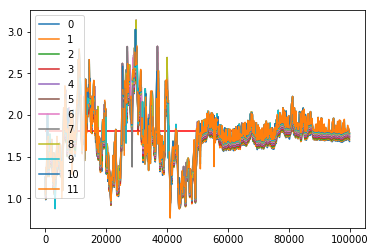

In [5]:
Plot_Y = np.array(Plot_Y)
for j in range(n_steps):
    Plot_n = Plot_Y[:,j,0]
    plt.plot(Plot_X, Plot_n)
plt.legend([j for j in range(n_steps)])
plt.hlines((mu - rf) / (Risk_Aversion * sigma**2), xmin= 0, xmax= n_episodes, color = 'r')

In [6]:
PNetwork.predict(np.append(s0, 11)) - PNetwork.predict(np.append(s0,0))

array([0.11346905])